<a href="https://colab.research.google.com/github/theoVasilas/Pattern_Recognition_weeklies/blob/main/erg_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [442]:
from sklearn import datasets
import pandas as pd
import numpy as np

iris = datasets.load_iris() #Importing data set 
iris.keys()

iris = pd.DataFrame(
    data= np.c_[iris['data'], iris['target']],
    columns= iris['feature_names'] + ['target']
    )

species = []

for i in range(len(iris['target'])):
    if iris['target'][i] == 0:
        species.append("setosa")
    elif iris['target'][i] == 1:
        species.append('versicolor')
    else:
        species.append('virginica')


iris['species'] = species

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


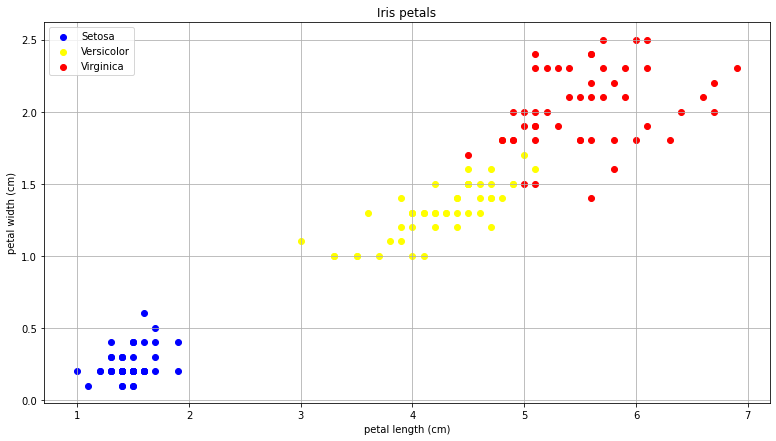

In [443]:
import matplotlib.pyplot as plt

setosa = iris[iris.species == "setosa"]
versicolor = iris[iris.species=='versicolor']
virginica = iris[iris.species=='virginica']

fig, ax = plt.subplots()
fig.set_size_inches(13, 7) # adjusting the length and width of plot

# lables and scatter points
ax.scatter(setosa['petal length (cm)'], setosa['petal width (cm)'], label="Setosa", facecolor="blue")
ax.scatter(versicolor['petal length (cm)'], versicolor['petal width (cm)'], label="Versicolor", facecolor="yellow")
ax.scatter(virginica['petal length (cm)'], virginica['petal width (cm)'], label="Virginica", facecolor="red")


ax.set_xlabel("petal length (cm)")
ax.set_ylabel("petal width (cm)")
ax.grid()
ax.set_title("Iris petals")
ax.legend()

iris.describe()

remuving unuseful columns

spliting to train data 80% and test data 20% with random selection

scaling data with 0 mean remaning the standar diviation

tranforming to tensorflow


In [444]:
from sklearn.model_selection import train_test_split
import torch
from sklearn.preprocessing import StandardScaler

# Droping the target and species since we only need the measurements
X = iris.drop(['target','species'], axis=1)

# converting into numpy array and assigning petal length and petal width
X = X.to_numpy()
y = iris['target'].to_numpy()

# Splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

print("Length of the test data : ", X_train.shape )
print("Length of the validation data : ", X_test.shape)


Length of the test data :  torch.Size([120, 4])
Length of the validation data :  torch.Size([30, 4])


In [445]:
import torch.nn as nn

class NN_Sigmoid(nn.Module):
    def __init__(self):
        super(NN_Sigmoid, self).__init__()
        #self.flatten = nn.Flatten()
        self.linear_stack = nn.Sequential(
            nn.Linear(4, 30),
            nn.Sigmoid(),
            nn.Linear(30,3),
        )

    def forward(self, x):
        #x = self.flatten(x)
        logits = self.linear_stack(x)
        return logits

class NN_ReLU(nn.Module):
    def __init__(self):
        super(NN_ReLU, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_stack = nn.Sequential(
            nn.Linear(4, 30),
            nn.ReLU(),
            nn.Linear(30,3),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_stack(x)
        return logits

class My_NN_Relu(nn.Module):
    def __init__(self):
        super(My_NN_Relu, self).__init__()
        #self.flatten = nn.Flatten()
        self.linear_stack = nn.Sequential(
            nn.Linear(4, 20),
            nn.ReLU(),
            nn.Linear(20,10),
            nn.ReLU(),
            nn.Linear(10,3),
        )

        # Define proportion or neurons to dropout
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        #x = self.flatten(x)
        logits = self.linear_stack(x)
        logits = self.dropout(logits)
        return logits

models = [ NN_Sigmoid() , NN_ReLU() , My_NN_Relu() ]
torch.save(models, 'models.pth') 

Create a trainuing loop 

In [446]:
def train_loop(model,optimizer,path_weigths,criterion,schedule,X_train,y_train,X_test,y_test,num_epochs,train_losses,test_losses):
    loss_train_old = 100
    for epoch in range(num_epochs):
        #clear out the gradients from the last step loss.backward()
        optimizer.zero_grad()

        # Compute prediction and loss
        #forward feed
        output_train = model(X_train)
        #calculate the loss
        loss_train = loss_fn(output_train, y_train)

        #backward propagation: calculate gradients
        loss_train.backward()
        #update the weights
        optimizer.step()

        #calculate train loss without optimizing model weights
        output_test = model(X_test)
        loss_test = criterion(output_test,y_test)

        train_losses[epoch] = loss_train.item()
        test_losses[epoch] = loss_test.item()
        correct_test = (output_test.argmax(1) == y_test).type(torch.float).sum().item()
            
        
        if (epoch + 1) % 50 == 0:
            print(f" Epoch {epoch+1}/{num_epochs}, Train Loss: {loss_train.item():.4f}, Test Loss: {loss_test.item():.4f}")
            correct_test /= len(X_test)
            print(f"Accuracy: {(100*correct_test):>0.1f}% \n")
        
        #save the best model weights if the train loss has decresed
        if train_losses[epoch] < loss_train_old :
          torch.save(model.state_dict(), path_weigths)
          loss_train_old = train_losses[epoch]
          print("saved ",end=" ")

    if schedule == 1 :
      #decreseng learning rate      
      scheduler.step()      


    print(f"Weights data have been saved in {(path_weigths)} \n")

In [447]:
def print_the_model(model):
  #print the model
  print(model)
  params = list(model.parameters())
  print("Number of learnable parameters' sets: " , len(params))
  for i in params:
    print(i.size()) 

model_selc = 2 ; #0:Sigmoid30 1:Relu30 2:MyNN
model = models[model_selc] ;

print_the_model(model)

My_NN_Relu(
  (linear_stack): Sequential(
    (0): Linear(in_features=4, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=3, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
)
Number of learnable parameters' sets:  6
torch.Size([20, 4])
torch.Size([20])
torch.Size([10, 20])
torch.Size([10])
torch.Size([3, 10])
torch.Size([3])


saved  saved  saved  saved  saved  saved  saved  saved  saved  saved  saved  saved  saved  saved  saved  saved  saved  saved  saved  saved  saved  saved  saved  saved  saved  saved  saved  saved  saved  saved  saved  saved  saved  saved  saved  saved  saved  saved   Epoch 50/1000, Train Loss: 0.2321, Test Loss: 0.2790
Accuracy: 90.0% 

saved  saved  saved  saved  saved  saved  saved  saved  saved  saved   Epoch 100/1000, Train Loss: 0.1911, Test Loss: 0.2172
Accuracy: 96.7% 

 Epoch 150/1000, Train Loss: 0.1841, Test Loss: 0.2242
Accuracy: 96.7% 

saved   Epoch 200/1000, Train Loss: 0.2102, Test Loss: 0.2070
Accuracy: 96.7% 

 Epoch 250/1000, Train Loss: 0.1987, Test Loss: 0.2211
Accuracy: 96.7% 

 Epoch 300/1000, Train Loss: 0.2035, Test Loss: 0.2063
Accuracy: 96.7% 

 Epoch 350/1000, Train Loss: 0.2003, Test Loss: 0.1945
Accuracy: 96.7% 

 Epoch 400/1000, Train Loss: 0.2175, Test Loss: 0.2196
Accuracy: 96.7% 

 Epoch 450/1000, Train Loss: 0.2235, Test Loss: 0.2853
Accuracy: 86.7% 

 

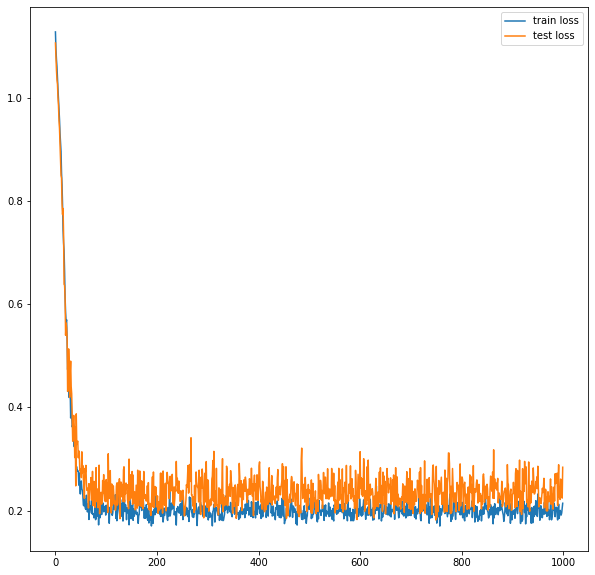

In [448]:
#number o iterations
num_epochs = 1000
train_losses = np.zeros(num_epochs)
test_losses  = np.zeros(num_epochs)

# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

schedule_en = 1 #true=1 false=0
if schedule_en==1:
  #step each time
  learning_rate = 0.01
else:
  learning_rate = 0.001

optimizer_SGD = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
optimizer_Adam = torch.optim.Adam(model.parameters(),lr=learning_rate)
optimizer_Adam_2 = torch.optim.Adam(model.parameters(),lr=learning_rate, weight_decay=0.05)
optimizers = [ optimizer_SGD , optimizer_Adam , optimizer_Adam_2 ]

path_weigths = ["best_weights_SGD.pth" , "best_weights_Adam.pth" , "best_weights_Adam_2.pth" ]

i = 2  # 0,1,2
PATH = path_weigths[i]
optimizer = optimizers[i]

#Decays the learning rate of each parameter group by gamma every epoch.
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# start training 
train_loop(model,optimizer,PATH,loss_fn,schedule_en,X_train,y_train,X_test,y_test,num_epochs,train_losses,test_losses)

plt.figure(figsize=(10,10))
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [449]:
print(f"load weights from {(PATH)}\n")
print_the_model(model)
#model.load_state_dict(torch.load(PATH))

load weights from best_weights_Adam_2.pth

My_NN_Relu(
  (linear_stack): Sequential(
    (0): Linear(in_features=4, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=3, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
)
Number of learnable parameters' sets:  6
torch.Size([20, 4])
torch.Size([20])
torch.Size([10, 20])
torch.Size([10])
torch.Size([3, 10])
torch.Size([3])


Confusion map for train

In [450]:
output_train = model(X_train)

from sklearn import metrics

print("Precision, Recall, Confusion matrix, in training\n")

# Precision Recall scores
print(metrics.classification_report(y_train, output_train.argmax(1) , digits=3))

# Confusion matrix
print(metrics.confusion_matrix(y_train, output_train.argmax(1) ))

Precision, Recall, Confusion matrix, in training

              precision    recall  f1-score   support

           0      0.952     1.000     0.976        40
           1      0.974     0.925     0.949        40
           2      0.950     0.950     0.950        40

    accuracy                          0.958       120
   macro avg      0.959     0.958     0.958       120
weighted avg      0.959     0.958     0.958       120

[[40  0  0]
 [ 1 37  2]
 [ 1  1 38]]


Confusion map for test

In [451]:
output_test = model(X_test)

from sklearn import metrics

print("Precision, Recall, Confusion matrix, in testing\n")

# Precision Recall scores
print(metrics.classification_report(y_test, output_test.argmax(1) , digits=3))

# Confusion matrix
print(metrics.confusion_matrix(y_test, output_test.argmax(1) ))

Precision, Recall, Confusion matrix, in testing

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        10
           1      0.900     0.900     0.900        10
           2      0.900     0.900     0.900        10

    accuracy                          0.933        30
   macro avg      0.933     0.933     0.933        30
weighted avg      0.933     0.933     0.933        30

[[10  0  0]
 [ 0  9  1]
 [ 0  1  9]]
